In [1]:

import torch
import torch.nn as nn
import torch.optim
import numpy as np 
import time
import gymnasium as gym
from highway_env.envs.your_env import YourEnv

In [2]:


class Actor(nn.Module):
    def __init__(self, state_dim, hidden_dim = 64, action_dim = 2, lr = 0.00005):
        super(Actor, self).__init__()
        self.hidden = nn.Linear(state_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, action_dim)
        self.relu = nn.ReLU()
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        
         # Create the learning rate schedulers
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=75, gamma=0.9)
        
    def forward(self, s):
        x = self.hidden(s)
        x = self.hidden2(self.relu(x))
        x = self.output(self.relu(x))
        return x

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim = 64, action_dim = 2, lr = 0.0001):
        super(Critic, self).__init__()
        self.hidden = nn.Linear(state_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
         # Create the learning rate schedulers
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=75, gamma=0.90)
        
    def forward(self, s):
        x = self.hidden(s)
        x = self.output(self.relu(x))
        return x

class Agent:
    def __init__(self, state_dim, hidden_dim, action_dim, 
                 lr_actor = 0.00005, lr_critic = 0.0001, gamma=0.99, 
                 scheduler = False, grad_clip = False):
        self.actor = Actor(state_dim, action_dim, hidden_dim, lr=lr_actor)
        self.critic = Critic(state_dim, hidden_dim, lr=lr_critic)
        
        self.action_dim = action_dim
        self.gamma = gamma
        self.log_probs = None
        
        self.scheduler = scheduler
        self.grad_clip = grad_clip
        

       
        
        
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        actor_output = self.actor(state) 
       
        # Generate normal distribution
        
        mu = actor_output[0][0]
        sigma = actor_output[0][1]
        
        sigma = torch.exp(sigma)
        
       
        action_probs = torch.distributions.Normal(mu, sigma)
        
        
        
        # Get one sample from each distribution
        
        probs = action_probs.sample(sample_shape = torch.Size([1,])) 
        self.log_probs = action_probs.log_prob(probs)
        action = torch.tanh(probs)
        
        return action


    def learn(self, state, reward, new_state, done):
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        
        critic_value_ = self.critic.forward(new_state)
        critic_value = self.critic.forward(state)
        
        # Calulate delta and loss with critic network output
        
        reward = torch.tensor(reward, dtype = torch.float32)
        delta = reward + self.gamma*critic_value_*(1 - int(done)) - critic_value
        
        actor_loss = -self.log_probs * delta
        critic_loss = delta**2
        
        
        (actor_loss.mean() + critic_loss).backward()
        
        if self.grad_clip:
        
            # Clip the gradients for both actor and critic
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
            
        self.actor.optimizer.step()
        self.critic.optimizer.step()
        
        if self.scheduler:
        
            # Step the learning rate schedulers
            self.actor.scheduler.step()
            self.critic.scheduler.step()  
        
 

In [3]:


# Create an instance of your custom environment
env = gym.make('merge-custom-v0', render_mode="rgb_array")
config = {
    "observation": {
        "type": "Kinematics",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [50, 50, 2, 2, 1, 1],
    },
    "action": {
        "type": "ContinuousAction",
        "lateral": False # No change of direction allowed
    },
    "vehicules_count": 1,
    "acceleration_range": [-1,1],
    "lateral": False,
    "simulation_frequency": 15,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "speed_reward": 0.0,
    "accel_penalty": 0.0,
    "collision_reward": -0.05,
    "forward_reward": 0.001,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": False,
}
env.unwrapped.configure(config)



In [4]:
# Training function for the agents

def train_agent(env, agent, number_of_episodes=500, max_steps=10):
    rewards = []

    for episode in range(number_of_episodes):
        initial_state = env.reset()
        state = initial_state[0]
        ep_reward = 0

        for step in range(max_steps):
            state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
            action = agent.select_action(state_tensor)

            next_state, reward, done, _, _ = env.step(action.detach().numpy())

            next_state_tensor = torch.tensor(next_state.flatten(), dtype=torch.float32)

            agent.learn(state_tensor, reward, next_state_tensor, done)
            state = next_state
            ep_reward += reward

            if done:
                break
        rewards.append(ep_reward)
        
    return rewards


In [5]:

# Test functions for agents

def test_agent(env, agent, num_test_episodes=10):
    avg_test_reward = []

    for episode in range(num_test_episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0

        for _ in range(15):
            env.render()  # Render the environment
            time.sleep(0.1)  # Pause a bit between frames for visibility

            state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
            action = agent.select_action(state_tensor)

            next_state, reward, done, _, _ = env.step(action.detach().numpy())
            state = next_state
            total_reward += reward

            if done:
                break
        avg_test_reward.append(total_reward)
        print(f"Test Episode {episode + 1}: Total Reward = {total_reward}")
    print(f"10 Episode Test: Average Reward = {np.array(avg_test_reward).mean()}")
    env.close()  # Close the environment when done

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot rewards function 

def plot_rewards(rewards):
    smoothed_rewards = pd.Series.rolling(pd.Series(rewards), 10).mean()
    smoothed_rewards_25 = pd.Series.rolling(pd.Series(rewards), 50).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    smoothed_rewards_25 = [elem for elem in smoothed_rewards_25]
    plt.plot(rewards, label='Rewards')
    plt.plot(smoothed_rewards, label='Smoothed rewards (10 episodes)')
    plt.plot(smoothed_rewards_25, label='Smoothed rewards (50 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

In [7]:
# Train function for reward weights tuning

def train_agent_dist(env, agent, number_of_episodes, max_steps):
    distances = []
    for episode in range(number_of_episodes):
        in_state = env.reset()
        state = in_state[0]
        initial_position = state[0][0]  # assuming the x position is the first element of the state
        done = False
        for step in range(max_steps):
            state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
            action = agent.select_action(state_tensor)

            next_state, reward, done, _, _ = env.step(action.detach().numpy())

            next_state_tensor = torch.tensor(next_state.flatten(), dtype=torch.float32)

            agent.learn(state_tensor, reward, next_state_tensor, done)
            state = next_state
            
            if done:
                break
        final_position = state[0][0]
        distance = final_position - initial_position
        distances.append(distance)
    return distances

In [8]:
env = gym.make('merge-custom-v0', render_mode="rgb_array")
config = {
    "observation": {
        "type": "Kinematics",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [50, 50, 2, 2, 1, 1],
    },
    "action": {
        "type": "ContinuousAction",
        "lateral": False
    },
    "vehicules_count": 1,
    "acceleration_range": [-1,1],
    "lateral": False,
    "simulation_frequency": 15,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "speed_reward": 0.0001,
    "accel_penalty": 0.0,
    "collision_reward": -0.06,
    "forward_reward": 0.001,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": False,
}
env.unwrapped.configure(config)


In [12]:

# RUN CELL 

state_dim = len(env.reset()[0].flatten())
action_dim = 2
hidden_dim = 64
agent = Agent(state_dim, action_dim, hidden_dim, 
                        lr_actor=1e-3, lr_critic=1e-4, 
                        gamma=0.99, scheduler = True, grad_clip = True)

# Train the agent

rewards = train_agent(env, agent, number_of_episodes=500, max_steps = 10)
avg_rewards = sum(rewards) / len(rewards)

avg_reward_last_20 = sum(rewards[-20:]) / len(rewards[-20:])




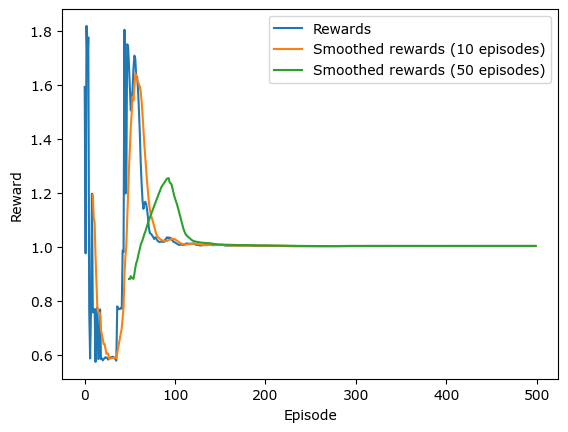

In [13]:
plot_rewards(rewards)

Training runs: 100%|██████████| 10/10 [28:49<00:00, 172.96s/it]


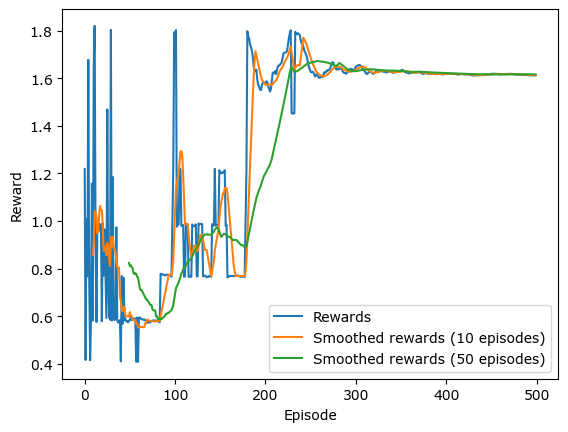

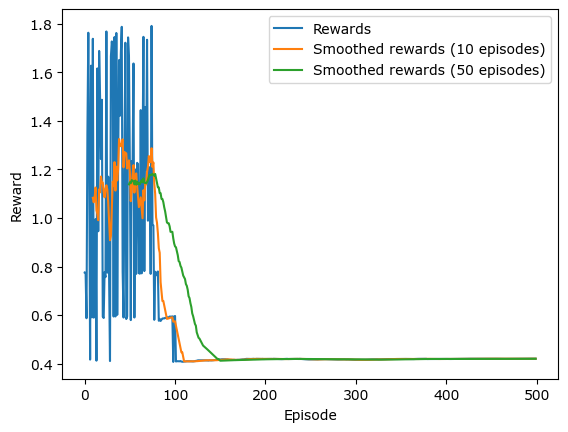

In [14]:
from tqdm import tqdm

# 10 Run model comparison 

num_runs = 10
all_rewards = []
best_rewards = None
worst_rewards = None
best_avg_reward_last_20 = -float('inf')
worst_avg_reward_last_20 = float('inf')

for run in tqdm(range(num_runs), desc="Training runs"):
    agent = Agent(state_dim, action_dim, hidden_dim, 
                  lr_actor=1e-3, lr_critic=1e-4, 
                  gamma=0.99, scheduler = True, grad_clip = True)

    # Train the agent
    rewards = train_agent(env, agent, number_of_episodes=500, max_steps = 10)
    avg_reward_last_20 = sum(rewards[-20:]) / len(rewards[-20:])

    if avg_reward_last_20 > best_avg_reward_last_20:
        best_avg_reward_last_20 = avg_reward_last_20
        best_rewards = rewards

    if avg_reward_last_20 < worst_avg_reward_last_20:
        worst_avg_reward_last_20 = avg_reward_last_20
        worst_rewards = rewards

    all_rewards.append(rewards)

# Plot the best and worst rewards
plot_rewards(best_rewards)
plot_rewards(worst_rewards)

In [15]:
# Model testing after training

test_agent(env,agent)


Test Episode 1: Total Reward = 0.42388757801701693
Test Episode 2: Total Reward = 0.4238819769751376
Test Episode 3: Total Reward = 0.4238815015732953
Test Episode 4: Total Reward = 0.42387458490183544
Test Episode 5: Total Reward = 0.42387976775937597
Test Episode 6: Total Reward = 0.4238869091562195
Test Episode 7: Total Reward = 0.42388115588598707
Test Episode 8: Total Reward = 0.42388227258190164
Test Episode 9: Total Reward = 0.42388959378009283
Test Episode 10: Total Reward = 0.42389368442085273
10 Episode Test: Average Reward = 0.4238839025051715


Initial training and grid search

In [ ]:
# Training loop 

out = env.reset()

# Initialize Agent
state_dim = len(out[0].flatten())
action_dim = 2
hidden_dim = 64
agent = Agent(state_dim, action_dim, hidden_dim, lr_actor = 1e-3, lr_critic = 1e-3, 
              gamma = 0.99, grad_clip= True, scheduler = True)

number_of_episodes = 500
max_steps = 10
rewards = []


for episode in range(number_of_episodes):
    initial_state = env.reset()
    state = initial_state[0]
    ep_reward = 0
    
    for step in range(max_steps):
        state_tensor = torch.tensor(state.flatten(), dtype = torch.float32)
        action = agent.select_action(state_tensor)
        
        next_state, reward, done, _, _ = env.step(action.detach().numpy())
        
        
        
        next_state_tensor = torch.tensor(next_state.flatten(), dtype = torch.float32)
        
        agent.learn(state_tensor, reward, next_state_tensor, done)
        state = next_state
        ep_reward += reward
        
        if done:
            break
    rewards.append(ep_reward)
    if episode % 2 == 0:
        print("Episode: {}, Total Reward: {:.2f}".format(episode, ep_reward))
import pandas as pd
import matplotlib.pyplot as plt


smoothed_rewards = pd.Series.rolling(pd.Series(rewards), 10).mean()
smoothed_rewards_50 = pd.Series.rolling(pd.Series(rewards), 50).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
smoothed_rewards_50 = [elem for elem in smoothed_rewards_50]
plt.plot(rewards)
plt.plot(smoothed_rewards)
plt.plot(smoothed_rewards_50)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

import time

# Number of episodes to test
num_test_episodes = 10

avg_test_reward = []

for episode in range(num_test_episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    for _ in range(10):
        env.render()  # Render the environment
        time.sleep(0.1)  # Pause a bit between frames for visibility

        state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
        action = agent.select_action(state_tensor)
        
        

        next_state, reward, done, _, _ = env.step(action.detach().numpy())
        state = next_state
        total_reward += reward
        
        if done:
            break
    avg_test_reward.append(total_reward)
    print(f"Test Episode {episode + 1}: Total Reward = {total_reward}")
print(f"10 Episode Test: Average Reward = {np.array(avg_test_reward).mean()}")
env.close()  # Close the environment when done

In [ ]:
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define hyperparameters to tune
learning_rates = [1e-3, 5e-4, 1e-4]
gammas = [0.99, 0.95, 0.9]
scheduler = [True, False]
grad_clip = [True, False]

best_avg_reward = float('-inf')
best_hyperparams = None

for gc in grad_clip:
    for scd in scheduler:
        for lr_actor in learning_rates:
            for lr_critic in learning_rates:
                for gamma in gammas:
                    # Initialize Agent
                    state_dim = len(env.reset()[0].flatten())
                    action_dim = 2
                    hidden_dim = 64
                    agent = Agent(state_dim, action_dim, hidden_dim, 
                                  lr_actor=lr_actor, lr_critic=lr_critic, 
                                  gamma=gamma, scheduler=scd, grad_clip=gc)

                    # Train the agent
                    try:
                        rewards = train_agent(env, agent, number_of_episodes = 300)
                    except:
                        continue
                    # Calculate average reward
                    avg_reward = sum(rewards) / len(rewards)

                    # Print results
                    print("lr_actor: {}, lr_critic: {}, gamma: {}, gc: {}, scd: {} --> Average Reward: {:.2f}".format(lr_actor, lr_critic, gamma, gc, scd, avg_reward))

                    # Update best hyperparameters if average reward improves
                    if avg_reward > best_avg_reward:
                        best_avg_reward = avg_reward
                        best_hyperparams = (lr_actor, lr_critic, gamma)

print("Best hyperparameters:", best_hyperparams)
print("Best average reward:", best_avg_reward)


lr_actor: 0.001, lr_critic: 0.001, gamma: 0.99, gc: True, scd: True --> Average Reward: 1.24
lr_actor: 0.001, lr_critic: 0.001, gamma: 0.95, gc: True, scd: True --> Average Reward: 1.40
lr_actor: 0.001, lr_critic: 0.001, gamma: 0.9, gc: True, scd: True --> Average Reward: 0.65
lr_actor: 0.001, lr_critic: 0.0005, gamma: 0.99, gc: True, scd: True --> Average Reward: 1.54
lr_actor: 0.001, lr_critic: 0.0005, gamma: 0.95, gc: True, scd: True --> Average Reward: 1.12
lr_actor: 0.001, lr_critic: 0.0005, gamma: 0.9, gc: True, scd: True --> Average Reward: 0.45
lr_actor: 0.001, lr_critic: 0.0001, gamma: 0.99, gc: True, scd: True --> Average Reward: 1.00
lr_actor: 0.001, lr_critic: 0.0001, gamma: 0.95, gc: True, scd: True --> Average Reward: 1.44
lr_actor: 0.001, lr_critic: 0.0001, gamma: 0.9, gc: True, scd: True --> Average Reward: 0.45
lr_actor: 0.0005, lr_critic: 0.001, gamma: 0.99, gc: True, scd: True --> Average Reward: 1.01
lr_actor: 0.0005, lr_critic: 0.001, gamma: 0.95, gc: True, scd: Tr

In [ ]:

# lr_actor: 0.001, lr_critic: 0.001, gamma: 0.99, gc: False, scd: True --> Average Reward: 1.55
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
agent = Agent(state_dim, action_dim, hidden_dim, 
                                  lr_actor=1e-3, lr_critic=1e-3, 
                                  gamma=0.99, scheduler=True, grad_clip=False)


try:
    rewards = train_agent(env, agent, number_of_episodes = 300)
    
    avg_reward = sum(rewards) / len(rewards)

    avg_last_50 = sum(rewards[-50:])/len(rewards[-50:])
    
    print("Avg reward : {}; Avg rew last 50: {}".format(avg_reward, avg_last_50))
except:
    print("Failed Training")
# Calculate average reward


Avg reward : 1.2003928161608384; Avg rew last 50: 1.1490354475522633


In [ ]:
forward_rew = [0.0, 0.001,0.0025, 0.005]
speed_rew = [0.0, 0.0001, 0.001]
collision_rew = [0.0, -0.05, -0.01, -0.1]

best_avg_reward = float('-inf')
best_hyperparams = None

for f_rew in forward_rew:
    for s_rew in speed_rew:
        for coll_p in collision_rew:
            env = gym.make('merge-custom-v0', render_mode="rgb_array")
            config = {
                "observation": {
                    "type": "Kinematics",
                    "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
                    "scales": [50, 50, 2, 2, 1, 1],
                },
                "action": {
                    "type": "ContinuousAction",
                    "lateral": False
                },
                "vehicules_count": 1,
                "acceleration_range": [-1,1],
                "lateral": False,
                "simulation_frequency": 15,  # [Hz]
                "policy_frequency": 1,  # [Hz]
                "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
                "screen_width": 600,  # [px]
                "screen_height": 150,  # [px]
                "centering_position": [0.3, 0.5],
                "scaling": 5.5,
                "speed_reward": s_rew,
                "accel_penalty": 0.0,
                "collision_reward": coll_p,
                "forward_reward": f_rew,
                "show_trajectories": False,
                "render_agent": True,
                "offscreen_rendering": False,
                "disable_collision_checks": False,
            }
            env.unwrapped.configure(config)
            
            
            state_dim = len(env.reset()[0].flatten())
            action_dim = 2
            hidden_dim = 64
            agent = Agent(state_dim, action_dim, hidden_dim, 
                                  lr_actor=1e-3, lr_critic=1e-3, 
                                  gamma=0.99, scheduler = True, grad_clip = False)
            
            # Train the agent
            try:
                rewards = train_agent(env, agent, number_of_episodes = 500)
            except:
                continue
            # Calculate average reward
            avg_reward = sum(rewards) / len(rewards)
            
            
            # Print results
            print("forw_rew: {}, speed_rew: {}, coll_pen: {},  --> Average Reward: {:.2f}".format(f_rew, s_rew, coll_p, avg_reward))

            
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                best_hyperparams = (f_rew, s_rew, coll_p)

forw_rew: 0.0, speed_rew: 0.0, coll_pen: 0.0,  --> Average Reward: 0.00
forw_rew: 0.0, speed_rew: 0.0, coll_pen: -0.05,  --> Average Reward: -0.02
forw_rew: 0.0, speed_rew: 0.0, coll_pen: -0.01,  --> Average Reward: -0.01
forw_rew: 0.0, speed_rew: 0.0, coll_pen: -0.1,  --> Average Reward: -0.05
forw_rew: 0.0, speed_rew: 0.0001, coll_pen: 0.0,  --> Average Reward: 0.02
forw_rew: 0.0, speed_rew: 0.0001, coll_pen: -0.05,  --> Average Reward: -0.02
forw_rew: 0.0, speed_rew: 0.0001, coll_pen: -0.01,  --> Average Reward: 0.01
forw_rew: 0.0, speed_rew: 0.0001, coll_pen: -0.1,  --> Average Reward: -0.04
forw_rew: 0.0, speed_rew: 0.001, coll_pen: 0.0,  --> Average Reward: 0.19
forw_rew: 0.0, speed_rew: 0.001, coll_pen: -0.05,  --> Average Reward: 0.17
forw_rew: 0.0, speed_rew: 0.001, coll_pen: -0.01,  --> Average Reward: 0.17
forw_rew: 0.0, speed_rew: 0.001, coll_pen: -0.1,  --> Average Reward: 0.15
forw_rew: 0.001, speed_rew: 0.0, coll_pen: 0.0,  --> Average Reward: 1.06
forw_rew: 0.001, speed

In [ ]:
forward_rew = [0.0, 0.001,0.0025, 0.005]
speed_rew = [0.0, 0.0001, 0.001]
collision_rew = [0.0, -0.05, -0.01, -0.1]

best_avg_reward = float('-inf')
best_hyperparams = None
best_avg_distance = 0

for f_rew in forward_rew:
    for s_rew in speed_rew:
        for coll_p in collision_rew:
            env = gym.make('merge-custom-v0', render_mode="rgb_array")
            config = {
                "observation": {
                    "type": "Kinematics",
                    "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
                    "scales": [50, 50, 2, 2, 1, 1],
                },
                "action": {
                    "type": "ContinuousAction",
                    "lateral": False
                },
                "vehicules_count": 1,
                "acceleration_range": [-1,1],
                "lateral": False,
                "simulation_frequency": 15,  # [Hz]
                "policy_frequency": 1,  # [Hz]
                "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
                "screen_width": 600,  # [px]
                "screen_height": 150,  # [px]
                "centering_position": [0.3, 0.5],
                "scaling": 5.5,
                "speed_reward": s_rew,
                "accel_penalty": 0.0,
                "collision_reward": coll_p,
                "forward_reward": f_rew,
                "show_trajectories": False,
                "render_agent": True,
                "offscreen_rendering": False,
                "disable_collision_checks": False,
            }
            env.unwrapped.configure(config)
            
            
            state_dim = len(env.reset()[0].flatten())
            action_dim = 2
            hidden_dim = 64
            agent = Agent(state_dim, action_dim, hidden_dim, 
                                  lr_actor=1e-3, lr_critic=1e-3, 
                                  gamma=0.99, scheduler = True, grad_clip = False)
            
            # Train the agent
            try:
                distances = train_agent_dist(env, agent, number_of_episodes=300, max_steps = 10)
            except :
                continue

            #distances = train_agent_dist(env, agent, number_of_episodes=300, max_steps = 20)
            
            # Calculate average distance
            avg_distance = sum(distances) / len(distances)
            
            avg_distance_last_20 = sum(distances[-20:]) / len(distances[-20:])

            # Print results
            print("forw_rew: {}, speed_rew: {}, coll_pen: {},  --> Average Distance: {:.2f}, Last 20 Average Distance: {:.2f}".format(f_rew, s_rew, coll_p, avg_distance, avg_distance_last_20))

            if avg_distance > best_avg_distance:
                best_avg_distance = avg_distance
                best_hyperparams = (f_rew, s_rew, coll_p)

forw_rew: 0.0, speed_rew: 0.0, coll_pen: 0.0,  --> Average Distance: 0.81, Last 20 Average Distance: 0.82
forw_rew: 0.0, speed_rew: 0.0, coll_pen: -0.05,  --> Average Distance: 0.81, Last 20 Average Distance: 0.81
forw_rew: 0.0, speed_rew: 0.0, coll_pen: -0.01,  --> Average Distance: 0.83, Last 20 Average Distance: 0.84
forw_rew: 0.0, speed_rew: 0.0, coll_pen: -0.1,  --> Average Distance: 0.39, Last 20 Average Distance: 0.35
forw_rew: 0.0, speed_rew: 0.0001, coll_pen: 0.0,  --> Average Distance: 0.84, Last 20 Average Distance: 0.85
forw_rew: 0.0, speed_rew: 0.0001, coll_pen: -0.05,  --> Average Distance: 0.85, Last 20 Average Distance: 0.84
forw_rew: 0.0, speed_rew: 0.0001, coll_pen: -0.01,  --> Average Distance: 0.80, Last 20 Average Distance: 0.82
forw_rew: 0.0, speed_rew: 0.0001, coll_pen: -0.1,  --> Average Distance: 0.81, Last 20 Average Distance: 0.80
forw_rew: 0.0, speed_rew: 0.001, coll_pen: 0.0,  --> Average Distance: 0.84, Last 20 Average Distance: 0.84
forw_rew: 0.0, speed_r